In [26]:
# Import PuLP modeler functions
!pip install pulp
from pulp import *
import random

In [31]:
# A list of strings from "1" to "9" is created
for nItems in [4,6,8,10,12,14]:#,16,18,20]:
    print("Number of Items:",nItems)
    Items = range(nItems)
    ItemPairs = list(itertools.permutations(Items,2))

    random.seed( 15 )

    height = {x: random.randint(1,20) for x in range(nItems)}
    width = {x: random.randint(1,20) for x in range(nItems)}
    itemValue = {x: height[x] * random.randint(0,3) + width[x] * random.randint(0,5) for x in range(nItems)}

    W = int(nItems**(1/2) * 10);
    H = int(nItems**(1/2) * 8);

    prob = LpProblem("2D Backpack",LpMaximize)

    # The problem variables are created
    packed = LpVariable.dicts("packed",(Items),0,1,LpInteger)
    rotated = LpVariable.dicts("rotated",(Items),0,1,LpInteger)
    x_origin = LpVariable.dicts("x_origin",(Items),0,W)
    y_origin = LpVariable.dicts("y_origin",(Items),0,H)

    x_overlap_right = LpVariable.dicts("x_overlap_right",(ItemPairs),0,1,LpInteger)
    x_overlap_left = LpVariable.dicts("x_overlap_left",(ItemPairs),0,1,LpInteger)
    y_overlap_above = LpVariable.dicts("y_overlap_above",(ItemPairs),0,1,LpInteger)
    y_overlap_below = LpVariable.dicts("y_overlap_below",(ItemPairs),0,1,LpInteger)

    # The arbitrary objective function is added
    prob += lpSum([packed[i]*itemValue[i] for i in Items]), "Objective Function"

    for (i,j) in ItemPairs:
        prob += x_origin[j] - x_origin[i] - (1-rotated[i])*width[i] - rotated[i] * height[i] + x_overlap_right[i,j] * 1000 >= 0, "overlap right %s %s" %(i,j)
        prob += x_origin[j] + (1-rotated[j])*width[j] + rotated[j]*height[j] - x_origin[i] - x_overlap_left[i,j] * 1000 <= 0, "overlap left %s %s" %(i,j)
        prob += y_origin[j] - y_origin[i] - (1-rotated[i]) * height[i] - rotated[i] * width[i] + y_overlap_above[i,j] * 1000 >= 0, "overlap above %s %s" %(i,j)
        prob += y_origin[j] + (1-rotated[j])*height[j] + rotated[j]*width[j] - y_origin[i] - y_overlap_below[i,j] * 1000 <= 0, "overlap below %s %s" %(i,j)
        prob += x_overlap_right[i,j] + x_overlap_left[i,j] + y_overlap_below[i,j] + y_overlap_above[i,j] <= 3 + 3*((1-packed[i])+(1-packed[j])), "no overlap %s %s" %(i,j)

    for i in Items:
        prob += x_origin[i] + (1-rotated[i])*width[i] + rotated[i]* height[i] <= W + (1-packed[i]) * 1000 , "maxWidth %i" %i
        prob += y_origin[i] + (1-rotated[i])*height[i] + rotated[i] * width[i] <= H + (1-packed[i]) * 1000, "maxHeight %i" %i

    prob += W*H >= lpSum([packed[i] * width[i] * height[i] for i in Items]), "maxArea"

    # The problem is solved using PuLP's choice of Solver
    prob.solve()
    #prob.solve(GUROBI_CMD())
    print("Status = %s" % LpStatus[prob.status])
    # Print the value of the objective
    print("Objective = %f" % value(prob.objective))
    # Which items are packed
    counter = 0
    for i in Items:
        if packed[i].varValue >= 0.9:
            print(packed[i])
            counter = counter + 1

    print("---------------------")

Number of Items: 4
Status = Optimal
Objective = 65.000000
packed_0
packed_1
packed_2
packed_3
---------------------
Number of Items: 6
Status = Optimal
Objective = 142.000000
packed_0
packed_1
packed_2
packed_3
packed_4
packed_5
---------------------
Number of Items: 8
Status = Optimal
Objective = 237.000000
packed_0
packed_1
packed_2
packed_3
packed_4
packed_5
packed_6
packed_7
---------------------
Number of Items: 10
Status = Optimal
Objective = 433.000000
packed_0
packed_1
packed_2
packed_3
packed_4
packed_5
packed_6
packed_7
packed_8
packed_9
---------------------
Number of Items: 12
Status = Optimal
Objective = 506.000000
packed_0
packed_1
packed_2
packed_3
packed_4
packed_5
packed_6
packed_7
packed_8
packed_9
packed_10
packed_11
---------------------
Number of Items: 14
Status = Optimal
Objective = 534.000000
packed_0
packed_1
packed_2
packed_3
packed_4
packed_5
packed_6
packed_7
packed_8
packed_9
packed_10
packed_11
packed_13
---------------------


9 : 0.0 0.0 8 12
13 : 0.0 0.0 16 15


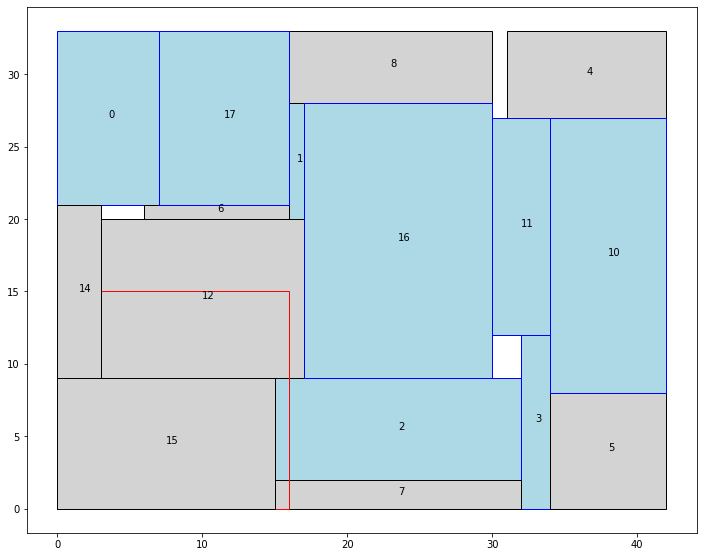

In [28]:
## import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 12]

plt.axes()
rectangle = plt.Rectangle((0,0), W, H, fc='white',ec="white")

# Create a Rectangle patch
for i in Items:
    if packed[i].varValue >= 0.9:
        if rotated[i].varValue == 0:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),width[i],height[i],edgecolor='black',facecolor='lightgray')
            plt.gca().add_patch(rect)
            centerx = width[i]  /2 + x_origin[i].varValue
            centery = height[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
        else:
            rect = patches.Rectangle((x_origin[i].varValue,y_origin[i].varValue),height[i],width[i],edgecolor='blue',facecolor='lightblue')
            plt.gca().add_patch(rect)
            centerx = height[i]  /2 + x_origin[i].varValue
            centery = width[i] /2 + y_origin[i].varValue 
            plt.text(centerx, centery,'%s'%i)
    if packed[i].varValue < 0.9:
        rect = patches.Rectangle((0,0),width[i],height[i],edgecolor='red',facecolor='none')
        plt.gca().add_patch(rect)
        print(i,":",x_origin[i].varValue,y_origin[i].varValue,width[i],height[i] )



plt.axis('scaled')
plt.show()

In [29]:
W

42

In [30]:
H

33